### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2019 ###

# Drone delivery syetem in Puerto Rico #

#### Liule Yang lyang338@wisc.edu, Matthew Zeimer mzeimer@wisc.edu, Shuaikun Hou shou34@wisc.edu

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
    1. [Assumptions](#2.A.-Assumptions)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Current Result](#4.A.-Current-Result)
  1. [Sensitivity Analysis on Wind Speed](#4.B.-Sensitivity-analysis-on-wind-speed)
  1. [Discussion](#4.C.-Discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

Our project is designed to find the minimal cost to deliver medical supplies in Puerto Rico area using drones. Developed from a tropic wave in middle September 2017, Hurricane Maria became one of the most detrimental storm in history, causing heavy casualties and huge loss of property in Puerto Rico area. A post-disaster relief is a primal concern for non-government orgnizations. Due to the failure of ground transportation and lack of resource of supplies, the rescue plan had to mostly rely on aircrafts and unmanned aerial vehicles to deliver emergency supplies.

In our project, we have several fixed locations of six warehouses storing three categories of medical supplies, and seven hospitals with daily supply demand. The drones will launch at warehouses, deliver the supplies to the hospitals, and finally come back to the warehouses they launched. There is a fixed one-time rent for each warehouse. Ideally, the drones will deliver all the supplies to the hopitals, but due to certain constrains like capacity of drones, we will need to purchase supplies for the hospitals with a higher cost. Our task is to ensure the medical supplies delivered by drones will meet the requirements of hospitals while minimizing the cost of the whole delivery process. The cost of the delivery process will include:

* The cost of drone pilots
* The cost of warehouses
* The cost due to defaulting (i.e. needs to purchse supplies for hospitals)
* The cost of purchasing drones

The problem is based on and revised from  [Problem B in Mathmetical Constest in Modeling (2019)](https://www.comap.com/undergraduate/contests/mcm/contests/2019/problems/). The data about hospital locations is based on real-world locations of hospitals in Puerto Rico, and the locations for warehouses are randomly selected. All the information about locations and distances is based on Google Map. Here is an overview of the map:
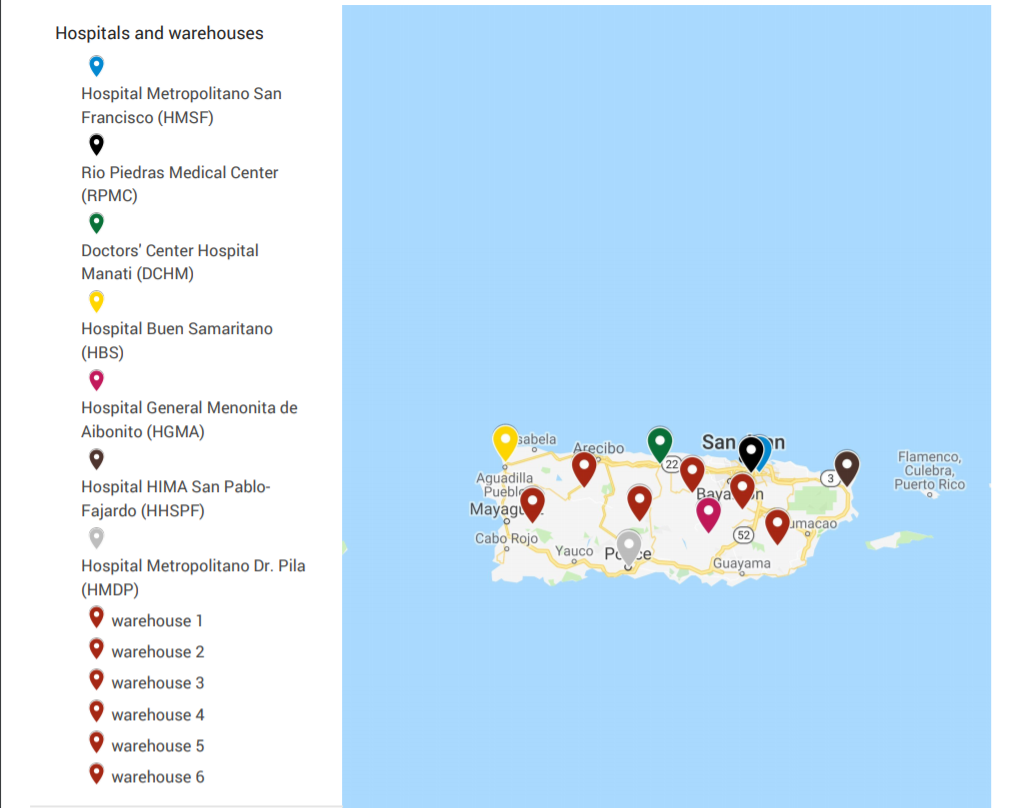

If you need more information on the detailed map, see [this reference](https://www.google.com/maps/d/u/0/edit?mid=1hGwIYSZJGXgDLQtJ7_ng166_EbRtHg0I&hl=en&ll=18.298808912815993%2C-66.63779678370747&z=10).

The data regarding to the weight of medical supplies, capacites of drones is also retrieved from the [Problem B in Mathmetical Constest in Modeling (2019)](https://www.comap.com/undergraduate/contests/mcm/contests/2019/problems/). The prices of different types of drones is based on the price of [industrial drones manufactured by DJI](https://store.dji.com/product/matrice-600-pro?from=menu_products), which is one of the most professional drone companies in the world. Other data like the cost of drone pilots, rent of warehouses, and price of medical supplies is made up. 

In the rest parts of the report, we will first present the development of the network-flow based mathematical model in our problem, present our solution in Julia language, perform sensitivity analysis to dicuss the result, and concludes the report by summerizing, discussing limitations, and discussing more possibilities. 

## 2. Mathematical model ##

### 2.A. Assumptions

In this project, there will be several assumptions:

1) The effect of wind will not be considered.

2) We do not consider the curved surface of the earth in this senario since Puerto Rico is relatively small

3) Altitude will not be considered

4) Each drone only goes to one hospital and then comes back

5) All the drones are flighing in straight lines



## 3. Solution ##

Below parts show the model describled above. The detail comments are included in the Julia code. To compile the code, please run the block in order.

Solving the code might take up to ten minutes.

In [7]:
##This block of code contains all the data

using JuMP, Gurobi, NamedArrays

#hospital and warehouse locations and distances between them

##sources and destinations
warehouses = [ 1,  2,  3, 4, 5, 6]
hospitals = [:A, :B, :C, :D, :E, :F, :G]

##distances from each warehouse to all the hospitals. Formatted in a NamedArray
dist = NamedArray( [67 65 41 19 51 91 31;
        51 48 23 24 38 76 26; 
        38 35 18 42 20 60 14; 
        20 18 12 55 13 45 28; 
        12 11 27 70 12 31 37;
        22 22 41 82 20 26 43;
        ], (warehouses,hospitals), ("Warehouses","Hospitals") )

##drone capacities for different types of drones, which are flow capacities
drone_capacity=[5,1,4]


#costs

##rents for six different warehouses
warehouse_costs = [15900 15300 15600 15350 15200 16500]

##cost for purchasing different types of drones
cost_per_drone=[6100,5500,4600]

##cost per mile for 3 different types of drones
cost_per_mile = [4,2,6]

##penalty cost for each type of supply (needs to buy at a higher price)
default_cost = [2100 1620 2500]

##supplies for three kinds of supplies at warehouses
supply_a = Dict(zip( warehouses, [21 27 33 31 14 32] ))
supply_b = Dict(zip( warehouses, [13 10 81 7 11 36] ))
supply_c = Dict(zip( warehouses, [6 13 2 8 26 13] ))

##demands for three types of supplies at hospitals
demand_a = Dict(zip( hospitals,  [14 15 7 35 3 14 26] ))
demand_b = Dict(zip( hospitals,  [18 11 1 39 7 18 21] ))
demand_c = Dict(zip( hospitals,  [4 8 15 2 5 11 21] ))

Dict{Symbol,Int64} with 7 entries:
  :F => 11
  :A => 4
  :G => 21
  :D => 2
  :B => 8
  :E => 5
  :C => 15

In [8]:
# This block shows the model itself and the variables

#Network-flow model and a mixed integer program
m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))

# VARIABLES:

## three flows, one for each supply type
@variable(m, x_a[warehouses,hospitals] >= 0)
@variable(m, x_b[warehouses,hospitals] >= 0)
@variable(m, x_c[warehouses,hospitals] >= 0)

#if activation[i] = 1, it means that the warehouse is rented
@variable(m, activation[1:6] >= 0, Bin)  

#if the demand a for any of the hospital is not met, we need to buy supplies for it
@variable(m, penality_a[hospitals]>=0, Int) 
@variable(m, penality_b[hospitals]>=0, Int) 
@variable(m, penality_c[hospitals]>=0, Int) 

## flow capacities represented by the carrying ability of each kind of drone
@variable(m, drones_m1[warehouses,hospitals] >= 0, Int)
@variable(m, drones_m2[warehouses,hospitals] >= 0, Int)
@variable(m, drones_m3[warehouses,hospitals] >= 0, Int)

# CONSTRAINTS:

## capacity constraint of drones
for i in warehouses
    for j in hospitals
        @constraint(m, drones_m1[i,j]*drone_capacity[1]+drones_m2[i,j]*drone_capacity[2]+drones_m3[i,j]*drone_capacity[3]
            >=x_a[i,j]+x_b[i,j]+x_c[i,j])
    end
end

## the logic constraint showing that if the supplies sent out at a warehouse is greater than zero, then it is activated
for i in 1:6
    @constraint(m, sum(x_a[i,j] + x_b[i,j] + x_c[i,j] for j in hospitals) <= 99999*activation[i] )
end

## supply constraints at warehouses
@constraint(m, sup_a[i in warehouses], sum(x_a[i,j] for j in hospitals) <= supply_a[i] )
@constraint(m, sup_b[i in warehouses], sum(x_b[i,j] for j in hospitals) <= supply_b[i] )
@constraint(m, sup_c[i in warehouses], sum(x_c[i,j] for j in hospitals) <= supply_c[i] )

## soft demand constraints including penalty costs
@constraint(m,dem_a[j in hospitals], sum(x_a[i,j] for i in warehouses) + penality_a[j] == demand_a[j] +1)
@constraint(m,dem_b[j in hospitals], sum(x_b[i,j] for i in warehouses) + penality_b[j] == demand_b[j] +1)
@constraint(m,dem_c[j in hospitals],sum(x_c[i,j] for i in warehouses) + penality_c[j] == demand_c[j] +1)


#OBJECTIVE:

## the objective function includes the cost of warehouses, cost of drones on the way,
## cost of purchasing drones, and cost of buying supplies for defaulting
@objective(m, Min, sum(warehouse_costs[i]*activation[i] for i in warehouses)
    + cost_per_mile[1]*sum(drones_m1[i,j]*dist[i,j] for i in warehouses, j in hospitals )
    + cost_per_mile[2]*sum(drones_m2[i,j]*dist[i,j] for i in warehouses, j in hospitals )
    + cost_per_mile[3]*sum(drones_m3[i,j]*dist[i,j] for i in warehouses, j in hospitals )
    + cost_per_drone[1]*sum(drones_m1[i,j] for i in warehouses, j in hospitals)
    + cost_per_drone[2]*sum(drones_m2[i,j] for i in warehouses, j in hospitals)
    + cost_per_drone[3]*sum(drones_m3[i,j] for i in warehouses, j in hospitals)
    +default_cost[1]*sum(penality_a[j] for j in hospitals)
    +default_cost[2]*sum(penality_b[j] for j in hospitals)
    +default_cost[3]*sum(penality_c[j] for j in hospitals))# minimize transportation cost

status = solve(m)

Academic license - for non-commercial use only


:Optimal

In [9]:
# nicely formatted solution
solution_a = NamedArray([getvalue(x_a[i,j]) for i in warehouses, j in hospitals], (warehouses,hospitals), ("warehouses","hospitals") )
solution_b = NamedArray([getvalue(x_b[i,j]) for i in warehouses, j in hospitals], (warehouses,hospitals), ("warehouses","hospitals") )
solution_c = NamedArray([getvalue(x_c[i,j]) for i in warehouses, j in hospitals], (warehouses,hospitals), ("warehouses","hospitals") )
println( solution_a )
println( solution_b )
println( solution_c )
println()
println(getvalue(penality_a))
println(getvalue(penality_b))
println(getvalue(penality_c))

println("Total cost will be \$", getobjectivevalue(m))

6×7 Named Array{Float64,2}
warehouses ╲ hospitals │   :A    :B    :C    :D    :E    :F    :G
───────────────────────┼─────────────────────────────────────────
1                      │  0.0   0.0   0.0   0.0   0.0   0.0   0.0
2                      │  0.0   0.0   0.0  27.0   0.0   0.0   0.0
3                      │  0.0   0.0   0.0   9.0   0.0   0.0  24.0
4                      │  0.0  15.0   8.0   0.0   4.0   0.0   2.0
5                      │ 10.0   1.0   0.0   0.0   0.0   0.0   0.0
6                      │  5.0   0.0   0.0   0.0   0.0  15.0   1.0
6×7 Named Array{Float64,2}
warehouses ╲ hospitals │   :A    :B    :C    :D    :E    :F    :G
───────────────────────┼─────────────────────────────────────────
1                      │  0.0   0.0   0.0   0.0   0.0   0.0   0.0
2                      │  0.0   0.0   0.0  10.0   0.0   0.0   0.0
3                      │  0.0   0.0   0.0  30.0   8.0   0.0  22.0
4                      │  0.0   5.0   2.0   0.0   0.0   0.0   0.0
5                     

## 4. Results and discussion ##

### 4.A. Current Result

Based on the code above, the current optimal cost with all assumptions held is 467740 dollars, and the detailed distribution is described in tables below.

#### Supply Type A:
From warehouse to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 Warehouse 1      |   0|  0| 0 | 0  | 0  | 0  |0
 Warehouse 2      |   0|  0| 0 |27  | 0  | 0  |0
 Warehouse 3      |   0|  0| 0 | 9  | 0  | 0  |24
 Warehouse 4      |   0| 15| 8 | 0  | 4  | 0  |2
 Warehouse 5      |  15|  1| 0 | 0  | 0  | 0  |0
 Warehouse 6      |   5|  0| 0 | 0  | 0  |15  |1
 
#### Supply Type B:
From warehouse to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 Warehouse 1      |   0|  0| 0 | 0  | 0  | 0  |0
 Warehouse 2      |   0|  0| 0 |10  | 0  | 0  |0
 Warehouse 3      |   0|  0| 0 |30  | 8  | 0  |22
 Warehouse 4      |   0|  5| 2 | 0  | 0  | 0  |0
 Warehouse 5      |   4|  7| 0 | 0  | 0  | 0  |0
 Warehouse 6      |  15|  0| 0 | 0  | 0  |19  |0
 
 #### Supply Type C:
 From warehouse to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 Warehouse 1      |   0|  0| 0 | 0  | 0  | 0  |0
 Warehouse 2      |   0|  0| 0 | 3  | 0  | 0  |10
 Warehouse 3      |   0|  0| 0 | 0  | 0  | 0  |2
 Warehouse 4      |   0|  0| 6 | 0  | 0  | 0  |2
 Warehouse 5      |   2|  8| 8 | 0  | 4  | 0  |4
 Warehouse 6      |   0|  0| 0 | 0  | 0  |10  |3
 
  #### We need to buy supplies:
  
   Type of supply to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 A      |   0|  0| 0 | 0  | 0  | 0  |0
 B      |   0|  0| 0 | 0  | 0  | 0  |0
 C      |   3|  1| 2 | 0  | 2  | 2  |1

### 4.B. Sensitivity Analysis on Wind Speed

However, sicne Puerto Rico area just endured a storm, the wind speed can affect the flight speed of drones to some extend. To make the drones perform normally, we need to reduce the drone capacities, and the damage cost and the pilot cost per mile will increase. We change some parameters and constraints to form a new model:

In [18]:
##A new model considering the wind speed

##This block of code contains all the data

using JuMP, Gurobi, NamedArrays

#hospital and warehouse locations and distances between them

##sources and destinations
warehouses = [ 1,  2,  3, 4, 5, 6]
hospitals = [:A, :B, :C, :D, :E, :F, :G]

##distances from each warehouse to all the hospitals. Formatted in a NamedArray
dist = NamedArray( [67 65 41 19 51 91 31;
        51 48 23 24 38 76 26; 
        38 35 18 42 20 60 14; 
        20 18 12 55 13 45 28; 
        12 11 27 70 12 31 37;
        22 22 41 82 20 26 43;
        ], (warehouses,hospitals), ("Warehouses","Hospitals") )

##drone capacities for different types of drones, which are flow capacities
## drone capacity decraese by one for the first and third type of drones
drone_capacity=[4,1,3]


#costs

##rents for six different warehouses
warehouse_costs = [15900 15300 15600 15350 15200 16500]

##cost for purchasing different types of drones
cost_per_drone=[6100,5500,4600]

##cost per mile for 3 different types of drones
## cost per mile increses by one for each type of drone
cost_per_mile = [5,3,7]

##penalty cost for each type of supply (needs to buy at a higher price)
default_cost = [2100 1620 2500]

##supplies for three kinds of supplies at warehouses
supply_a = Dict(zip( warehouses, [21 27 33 31 14 32] ))
supply_b = Dict(zip( warehouses, [13 10 81 7 11 36] ))
supply_c = Dict(zip( warehouses, [6 13 2 8 26 13] ))

##demands for three types of supplies at hospitals
demand_a = Dict(zip( hospitals,  [14 15 7 35 3 14 26] ))
demand_b = Dict(zip( hospitals,  [18 11 1 39 7 18 21] ))
demand_c = Dict(zip( hospitals,  [4 8 15 2 5 11 21] ))

Dict{Symbol,Int64} with 7 entries:
  :F => 11
  :A => 4
  :G => 21
  :D => 2
  :B => 8
  :E => 5
  :C => 15

In [19]:
# This block shows the model itself and the variables

#Network-flow model and a mixed integer program
m1 = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))

# VARIABLES:

## three flows, one for each supply type
@variable(m1, x_a[warehouses,hospitals] >= 0)
@variable(m1, x_b[warehouses,hospitals] >= 0)
@variable(m1, x_c[warehouses,hospitals] >= 0)

#if activation[i] = 1, it means that the warehouse is rented
@variable(m1, activation[1:6] >= 0, Bin)  

#if the demand a for any of the hospital is not met, we need to buy supplies for it
@variable(m1, penality_a[hospitals]>=0, Int) 
@variable(m1, penality_b[hospitals]>=0, Int) 
@variable(m1, penality_c[hospitals]>=0, Int) 

## flow capacities represented by the carrying ability of each kind of drone
@variable(m1, drones_m1[warehouses,hospitals] >= 0, Int)
@variable(m1, drones_m2[warehouses,hospitals] >= 0, Int)
@variable(m1, drones_m3[warehouses,hospitals] >= 0, Int)

# CONSTRAINTS:

## capacity constraint of drones
for i in warehouses
    for j in hospitals
        @constraint(m1, drones_m1[i,j]*drone_capacity[1]+drones_m2[i,j]*drone_capacity[2]+drones_m3[i,j]*drone_capacity[3]
            >=x_a[i,j]+x_b[i,j]+x_c[i,j])
    end
end

## the logic constraint showing that if the supplies sent out at a warehouse is greater than zero, then it is activated
for i in 1:6
    @constraint(m1, sum(x_a[i,j] + x_b[i,j] + x_c[i,j] for j in hospitals) <= 99999*activation[i] )
end

## supply constraints at warehouses
@constraint(m1, sup_a[i in warehouses], sum(x_a[i,j] for j in hospitals) <= supply_a[i] )
@constraint(m1, sup_b[i in warehouses], sum(x_b[i,j] for j in hospitals) <= supply_b[i] )
@constraint(m1, sup_c[i in warehouses], sum(x_c[i,j] for j in hospitals) <= supply_c[i] )

## soft demand constraints including penalty costs
@constraint(m1,dem_a[j in hospitals], sum(x_a[i,j] for i in warehouses) + penality_a[j] == demand_a[j] +1)
@constraint(m1,dem_b[j in hospitals], sum(x_b[i,j] for i in warehouses) + penality_b[j] == demand_b[j] +1)
@constraint(m1,dem_c[j in hospitals],sum(x_c[i,j] for i in warehouses) + penality_c[j] == demand_c[j] +1)


#OBJECTIVE:

## the objective function includes the cost of warehouses, cost of drones on the way,
## cost of purchasing drones, and cost of buying supplies for defaulting
@objective(m1, Min, sum(warehouse_costs[i]*activation[i] for i in warehouses)
    + cost_per_mile[1]*sum(drones_m1[i,j]*dist[i,j] for i in warehouses, j in hospitals )
    + cost_per_mile[2]*sum(drones_m2[i,j]*dist[i,j] for i in warehouses, j in hospitals )
    + cost_per_mile[3]*sum(drones_m3[i,j]*dist[i,j] for i in warehouses, j in hospitals )
    + cost_per_drone[1]*sum(drones_m1[i,j] for i in warehouses, j in hospitals)
    + cost_per_drone[2]*sum(drones_m2[i,j] for i in warehouses, j in hospitals)
    + cost_per_drone[3]*sum(drones_m3[i,j] for i in warehouses, j in hospitals)
    +default_cost[1]*sum(penality_a[j] for j in hospitals)
    +default_cost[2]*sum(penality_b[j] for j in hospitals)
    +default_cost[3]*sum(penality_c[j] for j in hospitals))# minimize transportation cost

status = solve(m1)

Academic license - for non-commercial use only


:Optimal

In [21]:
# nicely formatted solution
solution_a = NamedArray([getvalue(x_a[i,j]) for i in warehouses, j in hospitals], (warehouses,hospitals), ("warehouses","hospitals") )
solution_b = NamedArray([getvalue(x_b[i,j]) for i in warehouses, j in hospitals], (warehouses,hospitals), ("warehouses","hospitals") )
solution_c = NamedArray([getvalue(x_c[i,j]) for i in warehouses, j in hospitals], (warehouses,hospitals), ("warehouses","hospitals") )
println( solution_a )
println( solution_b )
println( solution_c )
println()
println(getvalue(penality_a))
println(getvalue(penality_b))
println(getvalue(penality_c))

println("Total cost will be \$", getobjectivevalue(m1))

6×7 Named Array{Float64,2}
warehouses ╲ hospitals │   :A    :B    :C    :D    :E    :F    :G
───────────────────────┼─────────────────────────────────────────
1                      │  0.0   0.0   0.0  20.0   0.0   0.0   1.0
2                      │  0.0   0.0   0.0  16.0   0.0   0.0  10.0
3                      │  0.0   0.0   0.0   0.0   0.0   0.0   0.0
4                      │  0.0   2.0   8.0   0.0   3.0   0.0  16.0
5                      │  0.0  14.0   0.0   0.0   0.0   0.0   0.0
6                      │ 15.0   0.0   0.0   0.0   1.0  15.0   0.0
6×7 Named Array{Float64,2}
warehouses ╲ hospitals │   :A    :B    :C    :D    :E    :F    :G
───────────────────────┼─────────────────────────────────────────
1                      │  0.0   0.0   0.0  13.0   0.0   0.0   0.0
2                      │  0.0   0.0   0.0   8.0   0.0   0.0   1.0
3                      │  0.0   0.0   0.0   0.0   0.0   0.0   0.0
4                      │  0.0   2.0   0.0   0.0   5.0   0.0   0.0
5                     

Based on the code above, the optimal cost considering the effect of wind speed is 578224 dollars, and the detailed distribution is described in tables below.

#### Supply Type A:
From warehouse to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 Warehouse 1      |   0|  0| 0 | 20  | 0  | 0  |1
 Warehouse 2      |   0|  0| 0 |16  | 0  | 0  |10
 Warehouse 3      |   0|  0| 0 | 0  | 0  | 0  |0
 Warehouse 4      |   0|  2| 8 | 0  | 3  | 0  |16
 Warehouse 5      |   0| 14| 0 | 0  | 0  | 0  |0
 Warehouse 6      |  15|  0| 0 | 0  | 1  |15  |0
 
#### Supply Type B:
From warehouse to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 Warehouse 1      |   0|  0| 0 | 13  | 0  | 0  |0
 Warehouse 2      |   0|  0| 0 |8  | 0  | 0  |0
 Warehouse 3      |   0|  0| 0 |0  | 0  | 0  |1
 Warehouse 4      |   0|  2| 0 | 0  | 5  | 0  |0
 Warehouse 5      |   2|  9| 0 | 0  | 0  | 0  |0
 Warehouse 6      |  17|  0| 0 | 0  | 1  |18  |0
 
 #### Supply Type C:
 From warehouse to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 Warehouse 1      |   0|  0| 0 | 3  | 0  | 0  |3
 Warehouse 2      |   0|  0| 0 | 0  | 0  | 0  |13
 Warehouse 3      |   0|  0| 0 | 0  | 0  | 0  |0
 Warehouse 4      |   0|  0| 8 | 0  | 0  | 0  |0
 Warehouse 5      |   5|  9| 8 | 0  | 4  | 0  |0
 Warehouse 6      |   0|  0| 0 | 0  | 2  |11  |0
 
  #### We need to buy supplies:
  
   Type of supply to hospitals|HMSF|RPMC|DCHM|HBS|HGMA|HHSPF|HMDP
 -------------    |----|---|---|----|----|----|----
 A      |   0|  0| 0 | 0  | 0  | 0  |0
 B      |   0|  1| 2 | 19  | 2  | 1  |21
 C      |   0|  0| 0 | 0  | 0  | 1  |6
 
 Based on the result above, when we take the effect of wind into account, the distribution is heavily changed, we need to buy more supplies due to supplies, and the cost increased substantially. Thus, we can conclude the wind can affect the system significantly.

### 4.C. Discussion

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.